## Description
Dataset contains nearly 32K tweets which are labeled based on having racist or sexist content. We are going to analyse this dataset and tweets, and by the end, create a classification model to classify tweets.   
Each row in the dataset has 3 columns:
* `id`: Assigned ID to this tweet by Analytics Vidhya.
* `label`: Tweet label, 1 if tweet has hatred content and 0 otherwise.
* `tweet`: Tweet text.  

Dataset is provided by [Analytics Vidhya](http://https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/)  

In [1]:
import numpy as np
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data = pd.read_csv('./data/train.csv')

How are tweets spread among these 2 classes?

In [2]:
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (data.label == 1).sum(),
    (data.label == 0).sum()
))

Hatred labeled: 2242
Non-hatred labeled: 29720


Classes are pretty much skewed, it's better to use F1 score as evaluation metric.

## Extracting features

#### Hashtags and mentions
We'll extract hashtags for each tweet as an extra column to explore them later.   
For user mentions, all of the usernames have been replaced with `'user'` so we can't get any data from it, we'll just remove mentions and keep the number of mentions in each tweet as an extra features for that tweet.  

In [3]:
hashtags = data['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
data.loc[:, 'hashtags'] = hashtags['hashtag']
data['hashtags'].fillna('', inplace=True)

data.loc[:, 'mentions'] = data['tweet'].str.count('@[a-zA-Z0-9_]+')

data.tweet = data.tweet.str.replace('@[a-zA-Z0-9_]+', '')

#### Removing anything but the words
Now we'll remove anything but the words (punctuations, numbers, etc). Note that this time we'll replace them with a blank space since it might be a `_` or `-` or a punctuation with no space from the next word and we don't want the words to join together.  

In [4]:
data.tweet = data.tweet.str.replace('[^a-zA-Z]', ' ')

#### Lemmatization
We lemmatize tweets' words as we have the sentences and we can tag part of speeches, and will stem hashtags.  

In [5]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, FreqDist, word_tokenize

stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()

part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}

def convert_tag(penn_tag):
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        return 'n'


def tag_and_lem(element):
    sent = pos_tag(word_tokenize(element))
    return ' '.join([lemmer.lemmatize(sent[k][0], convert_tag(sent[k][1][0]))
                    for k in range(len(sent))])
    

data.loc[:, 'tweet'] = data['tweet'].apply(lambda x: tag_and_lem(x))
data.loc[:, 'hashtags'] = data['hashtags'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


#### Frequent words
Now let's see what words and hashtags are the most frequenst in hate tweets and in total.

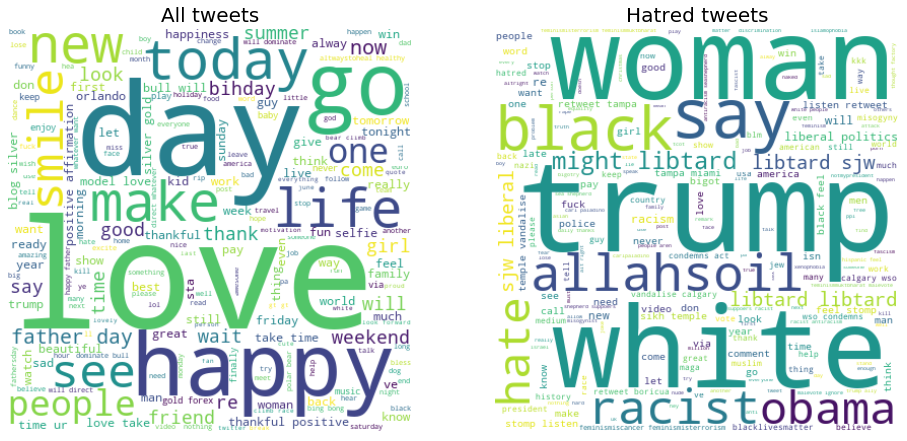

In [6]:
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

all_words = ' '.join(data.tweet.values)
hatred_words = ' '.join(data[data.label == 1].tweet.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(all_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('All tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

#### Hashtags
Now let's see which hashtags are used the most in hatred tweets and in total.

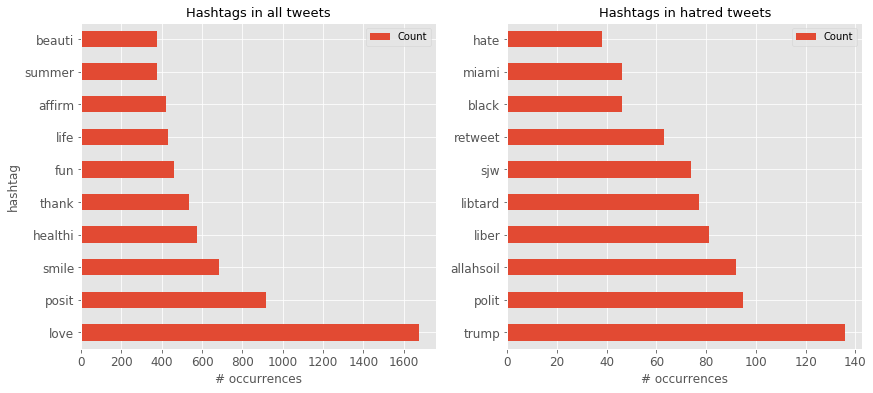

In [7]:
all_hashtags = FreqDist(list(' '.join(data.hashtags.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(data[data.label==1].hashtags.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

#### Mentions
Let's see how many mentions are there in total and if they can be of any use

In [8]:
print("Number of mentions: {}\nNumber of tweets having a mention: {}\nCorrelation with label: {}".format(
    data.mentions.sum(),
    len(data[data.mentions > 0]),
    np.corrcoef(data.mentions, data.label)[0][1]
))

Number of mentions: 17571
Number of tweets having a mention: 11126
Correlation with label: 0.07851491623991753


There is no meaningful relation between number of mentions and it looks like there is not a correlation either. So we'll remove number of mentions and won't use it as a feature.  

In [9]:
data.drop('mentions', axis=1, inplace=True)

#### Tfidf vectorizing
Now we use the frequency of each word in tweets as our features

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), min_df=10)
features = vectorizer.fit_transform(data.tweet)

In [11]:
features

<31962x4305 sparse matrix of type '<class 'numpy.float64'>'
	with 218714 stored elements in Compressed Sparse Row format>

In [12]:
data.label

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64

## Classifying
We'll build a SVC and a LogsiticRegression model for classifying our tweets.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score 

X_train, X_test, y_train, y_test = train_test_split(features, data.label)

In [14]:
X_train, y_train

(<23971x4305 sparse matrix of type '<class 'numpy.float64'>'
 	with 164051 stored elements in Compressed Sparse Row format>,
 16669    0
 7131     1
 11553    0
 29283    0
 21952    0
         ..
 4726     0
 3380     0
 8692     0
 25722    0
 5886     0
 Name: label, Length: 23971, dtype: int64)

In [15]:
X_test, y_test

(<7991x4305 sparse matrix of type '<class 'numpy.float64'>'
 	with 54663 stored elements in Compressed Sparse Row format>,
 1271     0
 29832    0
 27311    0
 15271    0
 15308    0
         ..
 31676    0
 27241    0
 17708    1
 4967     0
 15602    0
 Name: label, Length: 7991, dtype: int64)

#### Logistic Regression

Best parameters found were {'C': 3, 'penalty': 'l1'} with F1 score of 0.63


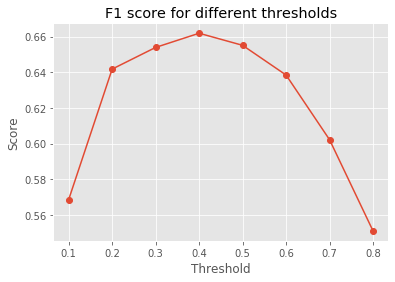

In [16]:
params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}
lrmodel = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=150), param_grid=params, scoring='f1', cv=5, n_jobs=-1)
lrmodel.fit(X_train, y_train)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    lrmodel.best_params_,
    lrmodel.best_score_
))
probas = lrmodel.predict_proba(X_test)
thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y_test, (probas[:, 1] >= x).astype(int)) for x in thresholds]
plt.plot(thresholds, scores, 'o-')
plt.title("F1 score for different thresholds")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.show()

In [17]:
y_pred = lrmodel.predict(X_test)

print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6550976138828634
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7441
           1       0.81      0.55      0.66       550

    accuracy                           0.96      7991
   macro avg       0.89      0.77      0.82      7991
weighted avg       0.96      0.96      0.96      7991



In [18]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [19]:
sns.set(rc={'figure.figsize':(7,5)})

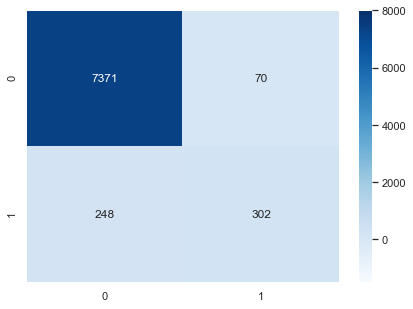

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", vmin=-1500, vmax=8000, cmap="Blues")

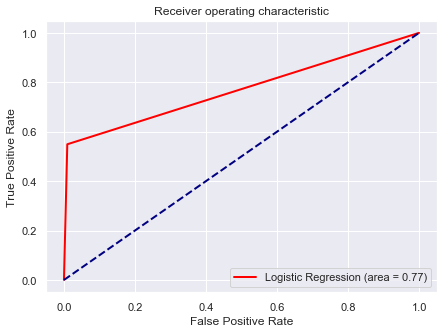

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred)
lw = 2
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='red', lw=lw, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

Best threshold found for our model is 0.4 so we will label any tweet with probability higher than or equal to 0.4 as hate tweet.

#### SVC

In [22]:
params = {'C': [1000, 3000, 9000, 15000]}
svc = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=params, scoring='f1', cv=3, n_jobs=-1)
svc.fit(X_train, y_train)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    svc.best_params_,
    svc.best_score_
))
predictions = svc.predict(X_test)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_test, predictions)))

Best parameters found were {'C': 9000} with F1 score of 0.64

F1 test score for SVC: 0.66


In [23]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7441
           1       0.78      0.57      0.66       550

    accuracy                           0.96      7991
   macro avg       0.87      0.78      0.82      7991
weighted avg       0.96      0.96      0.96      7991



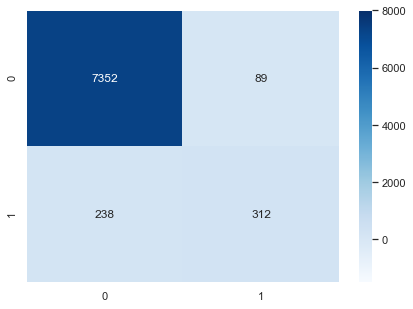

In [24]:
cm1 = confusion_matrix(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt="d", vmin=-1500, vmax=8000, cmap="Blues")

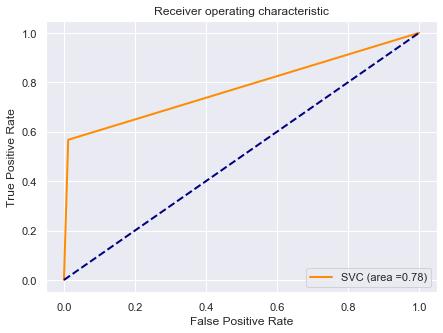

In [25]:
from sklearn import metrics

fpr_svc, tpr_svc, thresholds_svc = metrics.roc_curve(y_test, predictions, pos_label=1)
roc_auc_svc = metrics.auc(fpr_svc, tpr_svc)
plt.figure()
lw = 2
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=lw, label='SVC (area ={0:.2f})'.format(roc_auc_svc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show();

In [26]:
from sklearn.naive_bayes import MultinomialNB
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

y_pred_NB = NB_model.predict(X_test)

print(f1_score(y_test, y_pred_NB))
print(classification_report(y_test, y_pred_NB))

fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test, y_pred_NB, pos_label=1)
roc_auc_nb = metrics.auc(fpr_nb, tpr_nb)

0.4947368421052632
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7441
           1       0.90      0.34      0.49       550

    accuracy                           0.95      7991
   macro avg       0.92      0.67      0.73      7991
weighted avg       0.95      0.95      0.94      7991



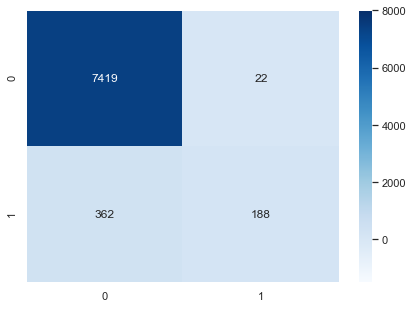

In [27]:
cmNB = confusion_matrix(y_test, y_pred_NB)
sns.heatmap(cmNB, annot=True, fmt="d", vmin=-1500, vmax=8000, cmap="Blues")

In [28]:
"""from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [700, 800, 1000],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [12,13,14],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

y_pred_random_forest = CV_rfc.predict(X_test)

print(f1_score(y_test, y_pred_random_forest))
print(classification_report(y_test, y_pred_random_forest))

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_random_forest, pos_label=1)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)"""

"from sklearn.ensemble import RandomForestClassifier\n\nparam_grid = { \n    'n_estimators': [700, 800, 1000],\n    #'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [12,13,14],\n    'criterion' :['gini', 'entropy']\n}\n\nCV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)\nCV_rfc.fit(X_train, y_train)\n\ny_pred_random_forest = CV_rfc.predict(X_test)\n\nprint(f1_score(y_test, y_pred_random_forest))\nprint(classification_report(y_test, y_pred_random_forest))\n\nfpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_random_forest, pos_label=1)\nroc_auc_rf = metrics.auc(fpr_rf, tpr_rf)"

In [29]:

"""from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred_random_forest = random_forest_model.predict(X_test)

print(f1_score(y_test, y_pred_random_forest))
print(classification_report(y_test, y_pred_random_forest))

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_random_forest, pos_label=1)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)"""

'from sklearn.ensemble import RandomForestClassifier\nrandom_forest_model = RandomForestClassifier()\nrandom_forest_model.fit(X_train, y_train)\n\ny_pred_random_forest = random_forest_model.predict(X_test)\n\nprint(f1_score(y_test, y_pred_random_forest))\nprint(classification_report(y_test, y_pred_random_forest))\n\nfpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_random_forest, pos_label=1)\nroc_auc_rf = metrics.auc(fpr_rf, tpr_rf)'

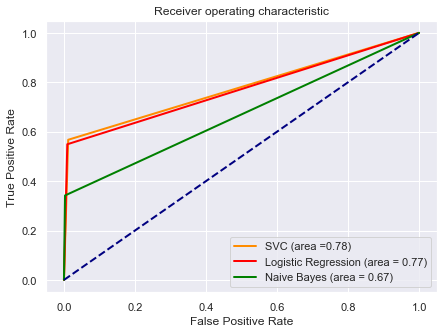

In [30]:
plt.figure()
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=lw, label='SVC (area ={0:.2f})'.format(roc_auc_svc))
plt.plot(fpr_lr, tpr_lr, color='red', lw=lw, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_nb, tpr_nb, color='green', lw=lw, label='Naive Bayes (area = %0.2f)' % roc_auc_nb)
#plt.plot(fpr_rf, tpr_rf, color='pink', lw=lw, label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

## Conclusion
We saw some of the most common words and hashtags in general and in racist/sexist tweets, extracted features by counting word tokens and Tfidf weighting them. We used unigrams, bigrams and trigrams as tokens.   
Finally, we built a logistic regression model and a support vector classifier to classify future tweets in these 2 classes.  

In [31]:
data_corona = pd.read_csv('./data/test_coronavirus_labeled.csv')

In [32]:
data_corona.head()

,Label,normalized_text
0,0,coronavirus around italian talking man undress...
1,1,gosh italian taking coronavirus threat really ...
2,0,long time since last week italian country citi...
3,0,italian really bullied year old chinese player...
4,1,million chinese trapped regime like forbidding...


In [33]:
vectorizer1 = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), min_df=10)
features1 = vectorizer1.fit_transform(data_corona.normalized_text)

In [34]:
features1

<3740x1403 sparse matrix of type '<class 'numpy.float64'>'
	with 49578 stored elements in Compressed Sparse Row format>

In [35]:
data_corona.normalized_text[data_corona.Label == 0].count()

2760

In [36]:
data_corona.normalized_text[data_corona.Label == 0].iloc[5]

'breaking seems italian taking chance potential coronavirus case heard cleared look like still going thing two confirmed rome nothing cruise ship'

In [37]:
data_corona.normalized_text[data_corona.Label == 1].iloc[2]


'plenty helpful gag coronavirus rinky dink mexican beer italian behind rhythm night'

In [38]:
# y_pred_corona = svc.predict(features1)
# uncomment when recuding the number of feature in the vectorizer

In [39]:
"""cm_corona = confusion_matrix(data_corona.Label, y_pred_corona)
sns.heatmap(cm_corona, annot=True, fmt="d", vmin=-1500, vmax=8000, cmap="YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')"""

'cm_corona = confusion_matrix(data_corona.Label, y_pred_corona)\nsns.heatmap(cm_corona, annot=True, fmt="d", vmin=-1500, vmax=8000, cmap="YlGnBu")\nplt.xlabel(\'Predicted Label\')\nplt.ylabel(\'True Label\')\nplt.title(\'Confusion Matrix\')'

In [40]:
""print(f1_score(data_corona.Label, y_pred_corona))
print(classification_report(data_corona.Label, y_pred_corona))""

SyntaxError: invalid syntax (<ipython-input-40-3018fe0bcbd2>, line 1)

In [ ]:
"""fpr_corona, tpr_corona, thresholds_corona = metrics.roc_curve(data_corona.Label, y_pred_corona, pos_label=1)
roc_auc_corona = metrics.auc(fpr_corona, tpr_corona)

plt.figure()
plt.plot(fpr_corona, tpr_corona, color='darkorange', lw=lw, label='SVC - corona (area ={0:.2f})'.format(roc_auc_corona))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()"""

In [ ]:
# BALANCED DATA
"""
train_imbalanced = data
from sklearn.utils import resample
df_majority = data[data.label==0]
df_minority = data[data.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
 
    
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("Before")
print(data.label.value_counts())
print("After upsampling")
print(df_upsampled.label.value_counts())
print("After downsampling")
print(df_downsampled.label.value_counts())
"""

In [ ]:
"""
vectorizer_up = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), min_df=10, max_features = 790)
features_up = vectorizer_up.fit_transform(df_downsampled.tweet)
"""

In [ ]:
"""
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(features_up, df_downsampled['label'], test_size=0.5, stratify=df_downsampled['label'])
"""

In [ ]:
"""
lrmodel_up = LogisticRegression(solver='liblinear', max_iter=150)
"""

In [ ]:
"""
lrmodel_up.fit(X_train_up, y_train_up)
"""

In [ ]:
"""
y_pred_up = lrmodel_up.predict(X_test_up)

print(f1_score(y_test_up, y_pred_up))
print(classification_report(y_test_up, y_pred_up))
"""

In [ ]:
"""
cm1 = confusion_matrix(y_test_up, y_pred_up)
sns.heatmap(cm1, annot=True, fmt="d", vmin=-1500, vmax=8000)
"""

In [ ]:
"""y_pred_up_complete = lrmodel_up.predict(X_test)

print(f1_score(y_test, y_pred_up_complete))
print(classification_report(y_test, y_pred_up_complete))"""

In [ ]:
"""cm_complete = confusion_matrix(y_test, y_pred_up_complete)
sns.heatmap(cm_complete, annot=True, fmt="d", vmin=-1500, vmax=8000)"""